In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import cv2
import statsmodels.api as sm
import scipy

/Users/Torgeir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Torgeir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
num_train_images = 100
num_test_images = 10

In [4]:
np.random.seed(0)

In [5]:
# parameters
n = (100,100) # size of grid
R = 40    # degree of continuity
 
## code
xx,yy = np.meshgrid(np.arange(0,n[0],1)-n[0]//2,np.arange(0,n[1],1)-n[1]//2)
C = np.exp(-3*np.sqrt(xx*xx+yy*yy)/R)
fftC = np.fft.fft2(C)

dataset = np.empty((0,100,100))
for i in range(num_train_images):
    fftN = np.fft.fft2(np.random.normal(size=n))
    sample = np.real(np.fft.ifft2(np.sqrt(np.abs(fftC))*fftN))
    dataset = np.concatenate((dataset, np.expand_dims(sample, axis=0)), axis=0)
 
dataset = (dataset-np.min(dataset))/(np.max(dataset)-np.min(dataset))
 
# plotting
#plt.imshow(sample)
#plt.colorbar()


In [6]:
test_dataset = np.empty((0,100,100))
for i in range(num_test_images):
    fftN = np.fft.fft2(np.random.normal(size=n))
    sample = np.real(np.fft.ifft2(np.sqrt(np.abs(fftC))*fftN))
    test_dataset = np.concatenate((test_dataset, np.expand_dims(sample, axis=0)), axis=0)
test_dataset = (test_dataset-np.min(test_dataset))/(np.max(test_dataset)-np.min(test_dataset))

In [7]:
def blur_image(dataset, kernel_size):
    im_shape = dataset.shape[1:]
    blur_kernel = np.ones(kernel_size)/(kernel_size[0]*kernel_size[1])
    blurred_dataset = np.empty((0,dataset.shape[1],dataset.shape[2]))
    for i in range(dataset.shape[0]):
        blurred_im = scipy.signal.correlate2d(dataset[i], blur_kernel, mode='same', boundary='fill', fillvalue=0) +  np.random.normal(0.0, 0.01, (100,100))# (np.random.random((100,100))-0.5)/20
        blurred_dataset = np.concatenate((blurred_dataset, np.expand_dims(blurred_im, axis=0)), axis=0)

    return blurred_dataset

In [8]:
blurred_images = blur_image(dataset, (5,5))


In [9]:
blurred_images_test =  blur_image(test_dataset, (5,5))

In [122]:
#plt.imshow(dataset[0])
#plt.colorbar()

In [123]:
#plt.imshow(blurred_images[0])
#plt.colorbar()

In [140]:
#randomSeed = np.real(np.fft.ifft2( np.fft.fft2(np.random.rand(100,100)) / np.sqrt(fftC)))

In [142]:
#plt.imshow(randomSeed)
#plt.colorbar()

In [ ]:
#randomSeed = np.real(np.fft.ifft2( np.fft.fft2(sample) / np.sqrt(fftC)))

In [12]:
def create_nbh_and_blur(ims, blurred_ims, nbh_size,blur_size):
    m, n = nbh_size
    h, w = blur_size
    h = h//2
    w = w//2
    train_dat = []
    blur_dat = []
    #train_dat = np.empty((70,0))
    for im, bl_im in zip(ims,blurred_ims):
        #print(im.shape)
        for i in range(m, ims.shape[1]-m):
                for j in range(n, ims.shape[1]-n):
                    
                    neighborhood = im[i+1-m:i+1,j-n:(j+n+1)]
                    flat_n = neighborhood.flatten()
                    blur_nbh = bl_im[i-h:i+h+1, j-w:j+w+1]
                    blur_nbh_flat = blur_nbh.flatten()[:]
                    dlt = n
                    
                    nbh_ij = flat_n[:-(dlt)]
                    #nbh_and_blur = np.concatenate((nbh_ij,blur_nbh_flat),axis = 0)
                    #print(nbh_and_blur.shape)
                    #train_dat.append(np.reshape(nbh_and_blur,(-1,1)))
                    train_dat.append(nbh_ij)
                    blur_dat.append(blur_nbh_flat)
                    #nbh_and_blur =  np.reshape(nbh_and_blur,(-1,1))
                    #print(nbh_and_blur.shape)
                    #train_dat = np.concatenate((train_dat, nbh_and_blur),axis=1)
    train_dat = np.array(train_dat)
    blur_dat = np.array(blur_dat)
    #nbh_and_blur = np.concatenate((train_dat,blur_dat),axis=1)
    nbh_and_blur = np.concatenate((blur_dat, train_dat),axis=1)
    return np.array(np.concatenate((np.ones((nbh_and_blur.shape[0],1)),nbh_and_blur),axis=1))



In [13]:
neighborhood_data = create_nbh_and_blur(ims=dataset, blurred_ims = blurred_images, nbh_size=(5,5), blur_size=(5,5))
np.array(neighborhood_data).shape

(810000, 76)

In [34]:
X_T_X = neighborhood_data[:,:-1].T@neighborhood_data[:,:-1]

In [35]:
eigval =np.linalg.eigvals(X_T_X)

In [36]:
vals, eigvec =np.linalg.eig(X_T_X)

In [14]:
#plt.plot(eigvec[:,0])

In [15]:
#plt.plot(eigval[10:])
#plt.grid()

In [ ]:
#aaa = np.random.random((100,100))
#aaa[23-2+1:23+2+2, 43-2:43+2+1]

In [ ]:
#aaa[23-2:23+2+1, 43-2:43+2+1]

In [ ]:
#aaa[23+1-5:23+1,43-5:(43+5+1)]

In [16]:
def lin_reg(train_dat):
    model = sm.OLS(train_dat[:,-1], train_dat[:,:-1])
    results = model.fit()
    betas = results.params
    
    y_pred = train_dat[:,1:-1]@betas[1:] + betas[0] 
    
    y_true = train_dat[:,-1]
    sigma2_hat = np.mean((y_true - y_pred)**2)

    return betas, sigma2_hat



In [17]:
parameters_estimate = lin_reg(neighborhood_data)

In [ ]:
#reg = LinearRegression(fit_intercept=False).fit(neighborhood_data[:,:-1], neighborhood_data[:,-1])

In [ ]:
#parameters_estimate =reg.coef_

In [ ]:
#parameters_estimate.shape

In [ ]:
#parameters_estimate[0][0]
#neighborhood_data[:,1]

In [39]:
parameters_estimate[1]

0.0007437702208936969

Text(0.5, 1.0, 'Beta estimates Gamma')

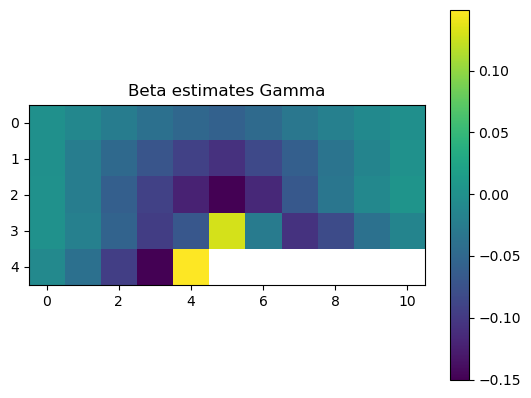

In [18]:
plt.imshow(np.concatenate((parameters_estimate[0][26:],np.array([np.inf,np.nan,np.nan,np.nan,np.nan,np.nan]))).reshape((5,11)))#,vmin=0)
plt.colorbar()
plt.title("Beta estimates Gamma")

#plt.savefig('../figures_blur/GRF_beta_est_nbh_blur.jpg')

Text(0.5, 1.0, 'Beta estimates Omega')

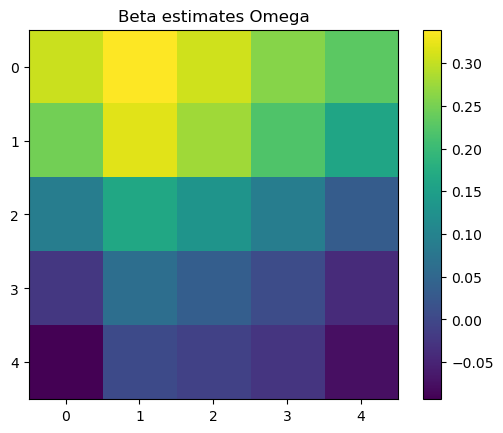

In [19]:
plt.imshow(parameters_estimate[0][1:26].reshape((5,5)))#,vmin=0)
plt.colorbar()
plt.title("Beta estimates Omega")
#plt.savefig('../figures_blur/GRF_beta_est_blur.jpg')


In [ ]:
np.sqrt(0.0010763107149353594)

In [20]:
def seq_sim(new_im, params, nbh_size, blur_size):
    betas, sigma2 = params
    #new_im = np.zeros(im_shape)
    #new_im = dataset[4]
    new_im_sample = new_im.copy()
    pred_im = new_im.copy()
    bl_im = new_im.copy()
    m, n = nbh_size
    h, w = blur_size
    h = h//2
    w = w//2
    for i in range(5, new_im.shape[0]-h):
        for j in range(n, new_im.shape[1]-n):
            #neighborhood = new_im[i-m:i,j-n:j+n+1]
            neighborhood = new_im_sample[(i+1-m):i+1,(j-n):(j+n+1)]
            blur_nbh = bl_im[i-h:i+h+1, j-w:j+w+1]
            flat_n = neighborhood.flatten()
            blur_nbh_flat = blur_nbh.flatten()[:]
            dlt = n

            #nbh_ij = flat_n[:-(dlt+1)]
            nbh_ij = flat_n[:-(dlt)]
            #mu_pred = np.dot(betas[:],nbh_ij)
            nbh_and_blur = np.concatenate((blur_nbh_flat,nbh_ij[:-1]))
            #mu_pred = nbh_ij[:-1]@betas[1:]+betas[0]
            mu_pred = nbh_and_blur@betas[1:]+betas[0]

            sample = np.random.normal(mu_pred, np.sqrt(sigma2))
            pred = mu_pred

            new_im_sample[i,j] = sample
            #pred_im[i,j] = pred

    return new_im_sample#pred_im #

In [21]:
seq_sim_sample = seq_sim(blurred_images_test[2],parameters_estimate, (5,5),blur_size=(5,5))

In [ ]:
seq_sim_sample2 = seq_sim(test_dataset[8],parameters_estimate, (5,5))

In [ ]:
seq_sim_sample3 = seq_sim(np.random.random((100,100)),parameters_estimate, (5,5))

In [ ]:
seq_sim_pred = seq_sim(test_dataset[7],parameters_estimate, (5,5))

In [ ]:
seq_sim_sample.shape

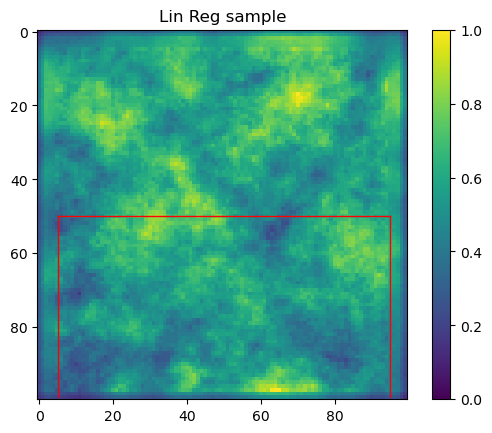

In [22]:
plt.imshow(seq_sim_sample, vmin=0,vmax=1)
x = [5, 95]
y = [50, 50]
xx = [5, 5]
yy = [50, 99]
xxx = [95, 95]
yyy = [50, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.title('Lin Reg sample')
#plt.savefig('../figures/GRF_sample_im1.jpg')
plt.show()

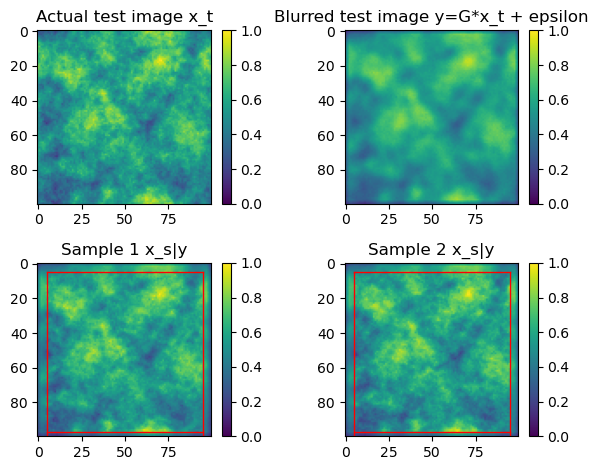

In [33]:
seq_sim_sample = seq_sim(blurred_images_test[2],parameters_estimate, (5,5),blur_size=(5,5))
seq_sim_sample_1 = seq_sim(blurred_images_test[2],parameters_estimate, (5,5),blur_size=(5,5))

fig, axes = plt.subplots(nrows=2, ncols=2)

im = axes.flat[0].imshow(test_dataset[2], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image x_t")

im = axes.flat[1].imshow(blurred_images_test[2], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred test image y=G*x_t + epsilon")

x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
xxxx = [5, 95]
yyyy = [97, 97]

axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
axes[1,0].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[2].imshow(seq_sim_sample, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("Sample 1 x_s|y")

axes[1,1].plot(x, y, color="red", linewidth=1)
axes[1,1].plot(xx, yy, color="red", linewidth=1)
axes[1,1].plot(xxx, yyy, color="red", linewidth=1)
axes[1,1].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[3].imshow(seq_sim_sample_1, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("Sample 2 x_s|y")
"""
axes[2,0].plot(x, y, color="red", linewidth=1)
axes[2,0].plot(xx, yy, color="red", linewidth=1)
axes[2,0].plot(xxx, yyy, color="red", linewidth=1)
axes[2,0].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[4].imshow(np.abs(test_dataset[2]-seq_sim_sample))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[2,0],fraction=0.046, pad=0.04)
axes[2,0].set_title("|Actual -  sampled|")

axes[2,1].plot(x, y, color="red", linewidth=1)
axes[2,1].plot(xx, yy, color="red", linewidth=1)
axes[2,1].plot(xxx, yyy, color="red", linewidth=1)
axes[2,1].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[5].imshow(np.abs(test_dataset[2]-seq_sim_sample_1))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[2,1],fraction=0.046, pad=0.04)
axes[2,1].set_title("|Actual -  sampled| 2")
"""

fig.tight_layout()
#fig.set_figheight(8)
#fig.set_figwidth(6)
plt.savefig('../figures_blur/GRF_sample_blur_1.jpg')
plt.show()

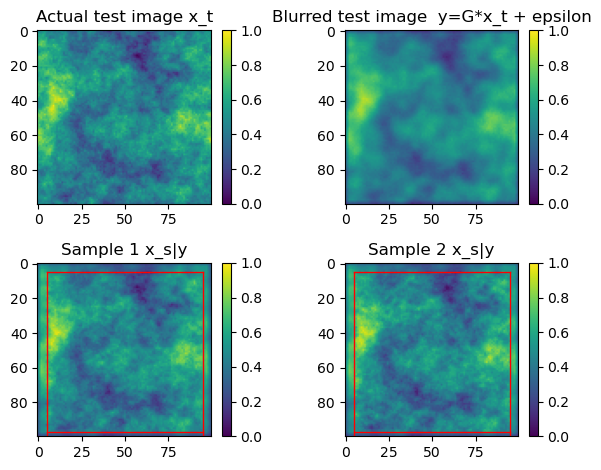

In [32]:
seq_sim_sample = seq_sim(blurred_images_test[8],parameters_estimate, (5,5),blur_size=(5,5))
seq_sim_sample_1 = seq_sim(blurred_images_test[8],parameters_estimate, (5,5),blur_size=(5,5))

fig, axes = plt.subplots(nrows=2, ncols=2)

im = axes.flat[0].imshow(test_dataset[8], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image x_t")

im = axes.flat[1].imshow(blurred_images_test[8], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred test image  y=G*x_t + epsilon")

x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
xxxx = [5, 95]
yyyy = [97, 97]

axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
axes[1,0].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[2].imshow(seq_sim_sample, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("Sample 1 x_s|y")

axes[1,1].plot(x, y, color="red", linewidth=1)
axes[1,1].plot(xx, yy, color="red", linewidth=1)
axes[1,1].plot(xxx, yyy, color="red", linewidth=1)
axes[1,1].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[3].imshow(seq_sim_sample_1, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("Sample 2 x_s|y")

"""
axes[2,0].plot(x, y, color="red", linewidth=1)
axes[2,0].plot(xx, yy, color="red", linewidth=1)
axes[2,0].plot(xxx, yyy, color="red", linewidth=1)
axes[2,0].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[4].imshow(np.abs(test_dataset[8]-seq_sim_sample))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[2,0],fraction=0.046, pad=0.04)
axes[2,0].set_title("|Actual -  sampled|")

axes[2,1].plot(x, y, color="red", linewidth=1)
axes[2,1].plot(xx, yy, color="red", linewidth=1)
axes[2,1].plot(xxx, yyy, color="red", linewidth=1)
axes[2,1].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[5].imshow(np.abs(test_dataset[8]-seq_sim_sample_1))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[2,1],fraction=0.046, pad=0.04)
axes[2,1].set_title("|Actual -  sampled| 2")



fig.set_figheight(8)
fig.set_figwidth(6)
"""
fig.tight_layout()
plt.savefig('../figures_blur/GRF_sample_blur_2.jpg')
plt.show()

In [170]:
#plt.imshow(np.abs(test_dataset[8]-seq_sim_sample))#,vmin=0,vmax=1)
#plt.colorbar()

In [ ]:
#sample 100 images and plot x_t - E(x_s), and var(x_s)

In [26]:
def blur_image_no_noise(dataset, kernel_size):
    im_shape = dataset.shape[1:]
    blur_kernel = np.ones(kernel_size)/(kernel_size[0]*kernel_size[1])
    blurred_dataset = np.empty((0,dataset.shape[1],dataset.shape[2]))
    for i in range(dataset.shape[0]):
        blurred_im = scipy.signal.correlate2d(dataset[i], blur_kernel, mode='same', boundary='fill', fillvalue=0) #+  np.random.normal(0.0, 0.01, (100,100))# (np.random.random((100,100))-0.5)/20
        blurred_dataset = np.concatenate((blurred_dataset, np.expand_dims(blurred_im, axis=0)), axis=0)

    return blurred_dataset

In [23]:
def y_minus_GX_samp(y,X_samp,num_samples):
    nnn = (y - blur_image_no_noise(X_samp, (5,5)))
    return nnn

In [29]:
X_sampled = np.expand_dims(seq_sim(blurred_images_test[8],parameters_estimate, (5,5),blur_size=(5,5)),axis=0)
#y_min_G_Xs = y_minus_GX_samp(blurred_images_test[8], np.expand_dims(seq_sim(blurred_images_test[8],parameters_estimate, (5,5),blur_size=(5,5)),axis=0), 1)
y_min_G_Xs = y_minus_GX_samp(blurred_images_test[8], X_sampled, 1)
G_X_sampled = blur_image_no_noise(X_sampled, (5,5))

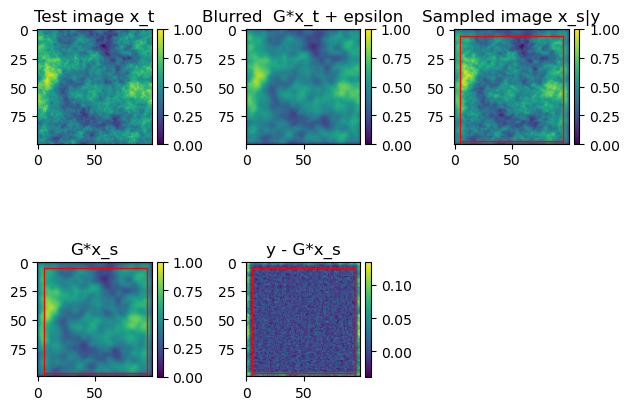

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=3)
x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
xxxx = [5, 95]
yyyy = [97, 97]

im = axes.flat[0].imshow(test_dataset[8], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Test image x_t")

im = axes.flat[1].imshow(blurred_images_test[8], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred  G*x_t + epsilon")

im = axes.flat[2].imshow(X_sampled[0], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("Sampled image x_s|y")
axes[0,2].plot(x, y, color="red", linewidth=1)
axes[0,2].plot(xx, yy, color="red", linewidth=1)
axes[0,2].plot(xxx, yyy, color="red", linewidth=1)
axes[0,2].plot(xxxx, yyyy, color="red", linewidth=1)

im = axes.flat[3].imshow(G_X_sampled[0], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("G*x_s")
axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
axes[1,0].plot(xxxx, yyyy, color="red", linewidth=1)

im = axes.flat[4].imshow(y_min_G_Xs[0])#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("y - G*x_s")
axes[1,1].plot(x, y, color="red", linewidth=1)
axes[1,1].plot(xx, yy, color="red", linewidth=1)
axes[1,1].plot(xxx, yyy, color="red", linewidth=1)
axes[1,1].plot(xxxx, yyyy, color="red", linewidth=1)

axes[1,2].set_visible(False)
fig.tight_layout()

plt.savefig('../figures_blur/CRF_y_min_GX_s_1.jpg')



In [27]:
def sample_many_ims(blurred_im,num_samples):

    blurred_samples = np.empty((0,blurred_im.shape[0],blurred_im.shape[1]))

    for i in range(num_samples):
        sample = seq_sim(blurred_im,parameters_estimate, (5,5),blur_size=(5,5))
        blurred_samples = np.concatenate((blurred_samples, np.expand_dims(sample, axis=0)), axis=0)
    return blurred_samples
        

In [28]:
many_samples = sample_many_ims(blurred_im=blurred_images_test[8],num_samples=100)

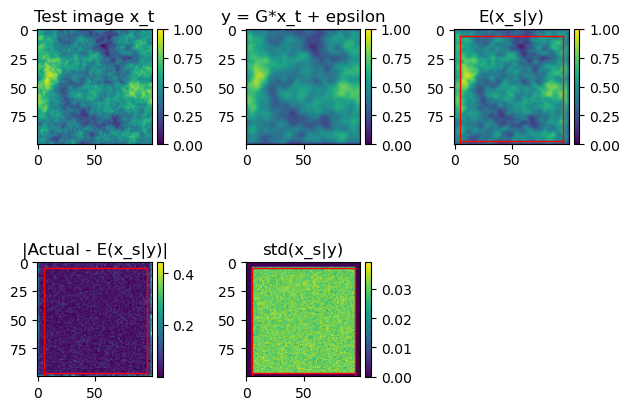

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=3)

im = axes.flat[0].imshow(test_dataset[8], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Test image x_t")

im = axes.flat[1].imshow(blurred_images_test[8], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("y = G*x_t + epsilon")

im = axes.flat[2].imshow(np.mean(many_samples, axis=0), vmin=0, vmax=1)#[0,5:97,5:95])#, vmin=0, vmax=1)[:,5:97,5:95]
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("E(x_s|y)")
axes[0,2].plot(x, y, color="red", linewidth=1)
axes[0,2].plot(xx, yy, color="red", linewidth=1)
axes[0,2].plot(xxx, yyy, color="red", linewidth=1)
axes[0,2].plot(xxxx, yyyy, color="red", linewidth=1)

im = axes.flat[3].imshow(np.abs(test_dataset[8]-np.mean(many_samples, axis=0)))#[0,5:97,5:95])#, vmin=0, vmax=1)[:,5:97,5:95][8,5:97,5:95]
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("|Actual - E(x_s|y)|")
axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
axes[1,0].plot(xxxx, yyyy, color="red", linewidth=1)

im = axes.flat[4].imshow(np.std(many_samples, axis=0))#[5:97,5:95])#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("std(x_s|y)")

axes[1,1].plot(x, y, color="red", linewidth=1)
axes[1,1].plot(xx, yy, color="red", linewidth=1)
axes[1,1].plot(xxx, yyy, color="red", linewidth=1)
axes[1,1].plot(xxxx, yyyy, color="red", linewidth=1)
axes[1,2].set_visible(False)

fig.tight_layout()

plt.savefig('../figures_blur/GRF_posterior_sample1.jpg')


In [143]:
import scipy.stats

In [166]:
def blur_image_no_noise2(image, kernel_size):
    #im_shape = dataset.shape[1:]
    blur_kernel = np.ones(kernel_size)/(kernel_size[0]*kernel_size[1])
    #blurred_dataset = np.empty((0,dataset.shape[0],dataset.shape[1]))
    #for i in range(dataset.shape[0]):
    blurred_im = scipy.signal.correlate2d(image, blur_kernel, mode='same', boundary='fill', fillvalue=0) #+  np.random.normal(0.0, 0.01, (100,100))# (np.random.random((100,100))-0.5)/20
    #blurred_dataset = np.concatenate((blurred_dataset, np.expand_dims(blurred_im, axis=0)), axis=0)

    return blurred_im# blurred_dataset

In [168]:
def evaluate_bayes_post(unblurred_im, eps_std, fftC, blurred_im, blur_size):
    loglik_prior = 0
    loglik_likelihood = 0
    
    prior_eval = np.real(np.fft.ifft2( np.fft.fft2(unblurred_im) / np.sqrt(fftC)))
    y_true = blurred_im.copy()
    #G_xs = blur_image_no_noise2(unblurred_im, blur_size)
    blur_kernel = np.ones(blur_size)/(blur_size[0]*blur_size[1])
    G_xs = scipy.signal.correlate2d(unblurred_im, blur_kernel, mode='same', boundary='fill', fillvalue=0)
    
    likelihood_prob = scipy.stats.norm.pdf(y_true, G_xs, eps_std)
    likelihood_prob =  np.clip(likelihood_prob, 0.0000000000001,None)
    
    prior_prob = scipy.stats.norm.pdf(prior_eval, 0, 1)
    prior_prob = np.clip(prior_prob, 0.0000000000001,None)

    loglik_prior = np.sum(np.log(prior_prob))
    loglik_likelihood = np.sum(np.log(likelihood_prob))

    return loglik_prior + loglik_likelihood

In [158]:
def evaluate_direct_post(parameters_estimate, blurred_im, gamma_size, omega_size):
    m, n = gamma_size
    h, w = omega_size
    h = h//2
    w = w//2
    
    total_log_likelihood = 0
    im_size = blurred_im.shape
    blur_im = blurred_im.copy()
    sample_im = np.zeros(im_size)
    
    betas, var_est = parameters_estimate
    
    #sample_im =
    for i in range(m, im_size[0]-h):
        for j in range(n, im_size[1]-n):
            neighborhood = sample_im[(i+1-m):i+1,(j-n):(j+n+1)]
            blur_nbh = blur_im[i-h:i+h+1, j-w:j+w+1]
            flat_n = neighborhood.flatten()
            blur_nbh_flat = blur_nbh.flatten()[:]
            dlt = n


            nbh_ij = flat_n[:-(dlt)]
            nbh_and_blur = np.concatenate((blur_nbh_flat,nbh_ij[:-1]))
            mu_pred = nbh_and_blur@betas[1:]+betas[0]

            sample = np.random.normal(mu_pred, np.sqrt(var_est))
            sample_im[i,j] = sample
            x_true = sample

            prob = scipy.stats.norm.pdf(x_true, mu_pred, np.sqrt(var_est))

            log_likelihood = np.log(prob)
    
            
            total_log_likelihood += log_likelihood


    return total_log_likelihood, sample_im

In [159]:
def importance_sampling(likelihoods, num_ims):
    bayes_loglik = likelihoods[:,1]
    direct_loglik = likelihoods[:,0]
    log_weights = np.zeros((num_ims,))
    for im in range(num_ims):
        log_weights[im] = bayes_loglik[im]-direct_loglik[im]
    log_weights = log_weights - np.max(log_weights)
    weights = np.exp(log_weights)/np.sum(np.exp(log_weights))
    #n_eff
    #E(x_s|y) = weighta*mean(x_s|y)

    return weights

In [160]:
def compare_direct_posterior(num_samples, im, gamma_size, omega_size, eps_std, blur_size):
    comparison = np.zeros((num_samples,2))
    for i in range(num_samples):
        comparison[i,0], unblr_im = evaluate_direct_post(parameters_estimate, im, gamma_size, omega_size)
        #unbl_im , _, _, _, _, _ = gen_im_mix(mlp_mix, blurred_testset[im,0], (5,5), (5,5))
        comparison[i,1] = evaluate_bayes_post(unblr_im, eps_std, fftC, im, blur_size)

    return comparison

In [170]:
def imp_samp_EX(im, num_samples, gamma_size, omega_size, eps_std, blur_size):
    #many_samples = sample_many_ims(blurred_im=blurred_testset[im,0],num_samples=num_samples)
    np.random.seed(0)
    #many_samples = sample_many_ims(blurred_im=torch.unsqueeze(blurred_testset[im], dim=0),num_samples=num_samples)
    many_samples = sample_many_ims(im, num_samples) #gen_im_mix_many_ims(pixel_cnn, (28,28), (5,5), torch.unsqueeze(blurred_testset[im],dim=0), (5,5), num_samples)
    #bayes_posterior = 
    log_likelihoods = compare_direct_posterior(num_samples, im, gamma_size, omega_size, eps_std, blur_size)
    weights = importance_sampling(log_likelihoods, num_samples)
    #weighted_ims = many_samples*weights
    weighted_ims = np.einsum('ijk,i->ijk',many_samples,weights)

    expected_ims = np.sum(weighted_ims,axis=0)
    #std_ims = np.std(weighted_ims, axis=0)
    std_ims = np.sqrt(np.sum(np.einsum('ijk,i->ijk',(many_samples-expected_ims)**2, weights),axis=0))
    n_eff = 1/np.sum(weights**2)
    return expected_ims, std_ims, n_eff, many_samples

In [176]:
E_xs_IS, std_xs_IS, N_eff_is, E_xs = imp_samp_EX(im=blurred_images_test[3], num_samples=200, gamma_size=(5,5), omega_size=(5,5), eps_std=0.01, blur_size=(5,5))

In [177]:
N_eff_is

1.0000000000000009

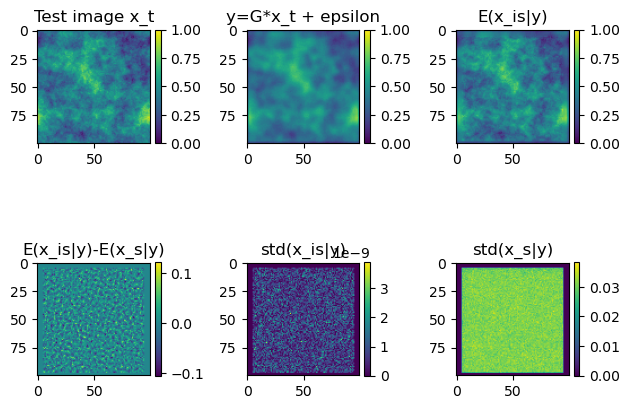

In [178]:
fig, axes = plt.subplots(nrows=2, ncols=3)

im = axes.flat[0].imshow(test_dataset[3], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Test image x_t")

im = axes.flat[1].imshow(blurred_images_test[3], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("y=G*x_t + epsilon")

im = axes.flat[2].imshow(E_xs_IS,vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,2],fraction=0.046, pad=0.04)
axes[0,2].set_title("E(x_is|y)")


im = axes.flat[3].imshow(E_xs_IS-np.mean(E_xs,axis=0))#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("E(x_is|y)-E(x_s|y)")


im = axes.flat[4].imshow(std_xs_IS)#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("std(x_is|y)")


im = axes.flat[5].imshow(np.std(E_xs, axis=0))#, vmin=0, vmax=1,)#[0,5:97,5:95])#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,2],fraction=0.046, pad=0.04)
axes[1,2].set_title("std(x_s|y)")


fig.tight_layout()

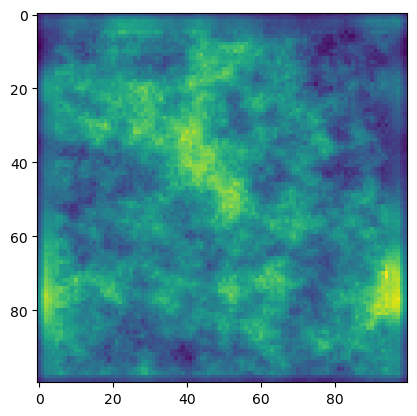

In [175]:
plt.imshow(E_xs_IS)

In [114]:
def chi_square(eps_std, num_samples, im):
    np.random.seed(0)
    many_samples = sample_many_ims(blurred_images_test[im],num_samples)
    blurred_many_samples = blur_image_no_noise(many_samples, (5,5))
    squared_residuals = (blurred_many_samples[:,4:97,5:95]-blurred_images_test[im,4:97,5:95])**2
    standard_residuals = squared_residuals/(eps_std**2)
    chi_square_res = np.sum(standard_residuals, axis=(1,2))
    return chi_square_res

In [115]:
chi_square1 = chi_square(0.01, 200, 7)

In [112]:
"""
plt.hist(chi_square1, bins=30, density=True,label='histogram')
x = np.arange(7000, 12000, 1)
df = 90*90
plt.plot(x, scipy.stats.chi2.pdf(x, df), label='Chi-square pdf, p=8100')
plt.legend()
plt.ylabel('probability')
plt.savefig('../figures_blur/linreg_Chi_square_2.jpg')
"""
print('wnsw')

wnsw


In [116]:
chi_square2 = chi_square(0.01, 200, 3)

In [121]:
np.mean(chi_square2)

10331.648539593787

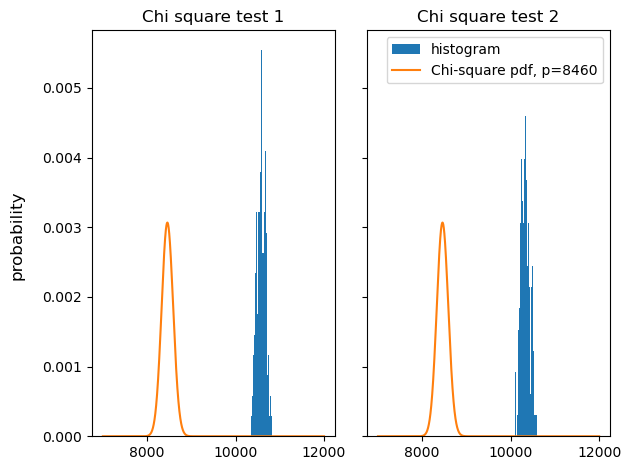

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=2,sharey=True)
x = np.arange(7000, 12000, 1)
df = 94*90

im = axes.flat[0].hist(chi_square1, bins=30, density=True,label='histogram')
im = axes.flat[0].plot(x, scipy.stats.chi2.pdf(x, df), label='Chi-square pdf, p=8460')
axes[0].set_title("Chi square test 1")

im = axes.flat[1].hist(chi_square2, bins=30, density=True,label='histogram')
im = axes.flat[1].plot(x, scipy.stats.chi2.pdf(x, df), label='Chi-square pdf, p=8460')
axes[1].set_title("Chi square test 2")
axes[1].legend()

fig.supylabel('probability')
fig.tight_layout()

plt.savefig('../figures_blur/linreg_Chi_square_both.jpg')


In [111]:
"""
plt.hist(chi_square2, bins=30, density=True,label='histogram')
x = np.arange(7000, 12000, 1)
df = 90*90
plt.plot(x, scipy.stats.chi2.pdf(x, df), label='Chi-square pdf, p=8100')
plt.legend()
plt.ylabel('probability')
plt.savefig('../figures_blur/linreg_Chi_square_2.jpg')
"""
print('jjsjsjs')

jjsjsjs


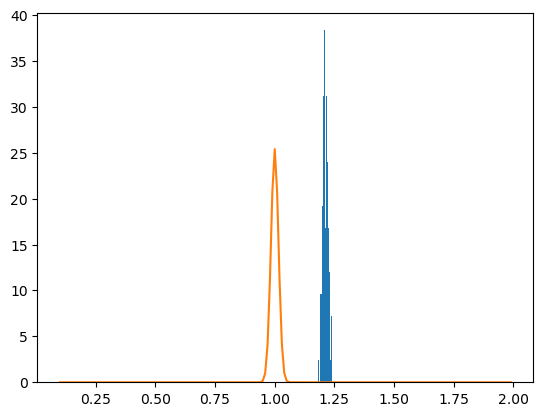

In [92]:

plt.hist(chi_square2/8100, bins=30, density=True,label='histogram')
x = np.arange(0.1, 2, 0.01)

plt.plot(x, scipy.stats.norm.pdf(x,1,np.sqrt(2*8100)/8100), label='Chi-square pdf, p=8100')

In [ ]:
plt.imshow(seq_sim_sample, vmin=0,vmax=1)
x = [5, 95]
y = [50, 50]
xx = [5, 5]
yy = [50, 99]
xxx = [95, 95]
yyy = [50, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.title('Lin Reg sample')
plt.savefig('../figures/GRF_sample_im1.jpg')
plt.show()

In [ ]:
plt.imshow(seq_sim_sample2, vmin=0,vmax=1)
x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.title('Lin Reg sample 2')
plt.savefig('../figures/GRF_sample_im2.jpg')
plt.show()

In [ ]:
plt.imshow(seq_sim_sample3, vmin=0,vmax=1)
x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [94, 94]
yyy = [5, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.title('Lin Reg sample random init')
plt.savefig('../figures/GRF_sample_im3.jpg')
plt.show()

In [ ]:
plt.imshow(seq_sim_pred, vmin=0,vmax=1)
x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.savefig('../figures/GRF_pred_im1.jpg')
plt.show()

In [ ]:
plt.imshow(test_dataset[7]-seq_sim_pred, vmin=0,vmax=1)

In [ ]:
from scipy.stats import norm

In [ ]:
x = np.arange(-0.2, 0.2, 0.0001)
plt.hist((test_dataset[7][5:,5:95]-seq_sim_pred[5:,5:95]).flatten(), bins=30, density=True,label="Residual")
plt.plot(x, norm.pdf(x, 0, np.sqrt(parameters_estimate[1])), label= 'N(0,sigma^2)')
plt.xlabel('Residual')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:
parameters_estimate[1]


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)#,sharex=True, sharey=True)

im = axes.flat[0].imshow(test_dataset[7], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image")

x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
axes[0,1].plot(x, y, color="red", linewidth=1)
axes[0,1].plot(xx, yy, color="red", linewidth=1)
axes[0,1].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[1].imshow(seq_sim_pred, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Predicted values")


axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[2].imshow(np.abs(test_dataset[7]-seq_sim_pred))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("|Actual - predicted|")
#axes.cax.colorbar(im)
#axes.cax.toggle_label(True)
#fig.colorbar(im)
#fig.tight_layout()
x = np.arange(-0.2, 0.2, 0.0001)
axes[1,1].hist((test_dataset[7][5:,5:95]-seq_sim_pred[5:,5:95]).flatten(), bins=30, density=True,label="Residual")
axes[1,1].plot(x, norm.pdf(x, 0, np.sqrt(parameters_estimate[1])), label= 'N(0,sigma^2)')
axes[1,1].set_xlabel('Residual')
axes[1,1].set_ylabel('Probability')
axes[1,1].legend(loc='upper right',fontsize='x-small')
#fig.set_figheight(5)
#fig.set_figwidth(14)
fig.tight_layout()
plt.savefig('../figures/GRF_pred_and_actual.jpg')
plt.show()

In [ ]:
#plot train im

#for i in range(1, 5):
#    plt.subplot(2, 2, i)
#    plt.imshow(dataset[i])
#plt.colorbar()
#plt.show()

In [ ]:
#plot train im

fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    im = ax.imshow(dataset[i+1], vmin=0, vmax=1)

image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('Example train images')
plt.savefig('../figures/GRF_train_im.jpg')#, image)
plt.show()

In [ ]:
image